# Your mission

You started working in a financial institution. You manager Mark is insterested in investing and trading **Bitcoin** to diversify his portfolio. So he turned to you to develop a crypto trading bot.

A **crypto trading bot** is a computer program with an underlying predictive model that automatically outputs a predicted day to day price for the next 30 days based on the history of Bitcoin market price and Blockchain variables. 

Your mission is to train an accurate predictive model with the lowest mean squared error. Mark is a very technical guy, he likes to understand all **technical details** and would like you to **compare the performances of classical models and neural-net based models**.

Your **target variable** is the Bitcoin Market price.

**Data source** : https://blockchain.info/

In [31]:
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler
import helper_functions as hf
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

import matplotlib.gridspec as gridspec
from copy import deepcopy
from datetime import datetime 
import itertools

CURDIR = os.path.dirname(os.getcwd())
DATADIR = os.path.join(CURDIR,  "data")
%matplotlib inline

# Data Exploration

In this section, you are to explore the data. You are to fulfill the following tasks:
- **Univariate analysis**
    - study the Bitcoin market price time series, in terms of its trend, cycle, seasonality, and stationnarity 
    - **Tips**: you can analyse ACF, PACF plots, perform Augmented Dickey-Fuller test
- **Multivariate analysis**
    - study other blockchain variables, retrieve insights
    - study the correlation between the Bitcoin market price and other blockchain variables 
    - **Tips**: Pearson correlation

In [2]:
df_blockchain = pd.read_csv(os.path.join(DATADIR, "df_blockchain.csv"), 
                            delimiter=",")
df_blockchain

,Date,market-price,n-transactions-per-block,median-confirmation-time,hash-rate,difficulty,miners-revenue,trade-volume,blocks-size,avg-block-size,...,cost-per-transaction,n-unique-addresses,n-transactions,n-transactions-total,n-transactions-excluding-popular,output-volume,estimated-transaction-volume,estimated-transaction-volume-usd,total-bitcoins,market-cap
0,2011-09-13,6.88,45.908451,0.000000,1.201882e+01,1.777774e+06,5.231801e+04,0.000000e+00,592.190091,0.019009,...,7.666766,12622.0,6519.0,1497195.0,6519.0,3.585436e+05,58615.641320,4.032756e+05,7.257416e+06,5.022014e+07
1,2011-09-14,6.19,42.465753,0.000000,1.326393e+01,1.755425e+06,4.830647e+04,0.000000e+00,594.907367,0.018007,...,7.369408,12408.0,6200.0,1503780.0,6200.0,3.026190e+05,74521.484625,4.612880e+05,7.264662e+06,4.540930e+07
2,2011-09-15,5.92,41.500000,0.000000,1.291487e+01,1.755425e+06,6.043144e+04,0.000000e+00,597.554226,0.018240,...,7.333913,12988.0,6474.0,1509972.0,6474.0,2.992261e+05,79422.402932,4.701806e+05,7.272284e+06,4.322228e+07
3,2011-09-16,5.58,52.176471,0.000000,1.099510e+01,1.755425e+06,3.434502e+04,0.000000e+00,600.362512,0.022136,...,5.466341,12059.0,6209.0,1516381.0,6209.0,6.746069e+05,82696.853247,4.614484e+05,7.279040e+06,4.088136e+07
4,2011-09-17,5.18,40.701493,0.000000,1.073331e+01,1.755425e+06,3.680591e+04,0.000000e+00,602.995510,0.017116,...,6.489054,10988.0,5454.0,1522600.0,5454.0,3.541989e+05,68238.166521,3.534737e+05,7.285375e+06,3.801833e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3539,2021-05-22,37280.35,1929.310345,16.916667,1.444278e+08,2.504649e+13,3.107614e+07,1.438210e+09,346378.108377,1.289550,...,138.856769,603588.0,223800.0,643953439.0,220859.0,2.363176e+06,134224.161048,5.042562e+09,1.871576e+07,6.998509e+11
3540,2021-05-23,37528.30,1632.941176,10.233333,1.481631e+08,2.504649e+13,2.894416e+07,6.660316e+08,346527.706387,1.379972,...,148.951003,555526.0,194320.0,644175796.0,191590.0,2.230243e+06,129391.707667,4.450530e+09,1.871650e+07,6.642670e+11
3541,2021-05-24,34754.54,1863.134921,10.725000,1.568785e+08,2.504649e+13,3.266880e+07,1.106858e+09,346691.878524,1.345943,...,139.161241,643231.0,234755.0,644370643.0,231931.0,2.610429e+06,193504.054960,7.207898e+09,1.871726e+07,6.847955e+11
3542,2021-05-25,38728.59,1899.544715,12.575000,1.531433e+08,2.504649e+13,3.257793e+07,1.032789e+09,346861.353216,1.359463,...,139.434045,640506.0,233644.0,644605027.0,231017.0,2.289845e+06,162716.569501,6.201345e+09,1.871804e+07,7.140334e+11


In [3]:
df_blockchain.columns.sort_values().shape

(23,)

In [4]:
# plt.figure(figsize = (40,30))
# plt.tick_params(labelsize=20)
# plt.plot(df_blockchain['market-price'][-100:])

In [5]:
# NaNs removal : all of them are in 'n-unique-addresses'

test = np.isnan(df_blockchain['n-unique-addresses'].to_numpy())
indices = np.nonzero(test)[0]

df_blockchain_no_nans = df_blockchain.drop(index=indices)


## Autocorrelation and Partial correlation

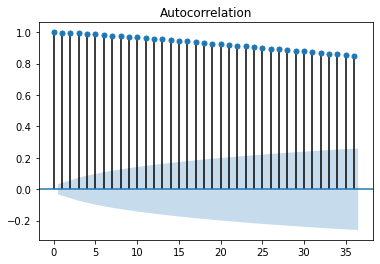

In [6]:
plot_acf(df_blockchain_no_nans["market-price"]);

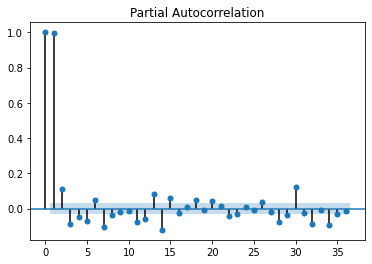

In [7]:
plot_pacf(df_blockchain_no_nans["market-price"]);

## Train test split

In [8]:
beginning_date = 2000
X_train, X_test = df_blockchain_no_nans[beginning_date:-30], df_blockchain_no_nans[-30:]


# Univariate analysis
In this section, you are to perform some classical modelings, the suggested method here is ARIMA, but you can try other models such as ARMA, ARIMAX, SARIMAX...

## Modeling with ARIMA
The following code allows ARIMA modeling with one combination of (p,d,q).

In [9]:
parameters = (1,1,2)
errors, predictions = hf.evaluate_arima_model(X_train["market-price"], 
                                              X_test["market-price"], parameters )
errors

2862.701794346939

### Search for the best ARIMA model
We use grid search to search for the best ARIMA parameters that gives the lowest error. This follows the Box-Jenkins methology.

In [10]:
# best_cfg, best_score = hf.arima_grid_search(X_train["market-price"], 
#                                             X_test["market-price"],
#                                             np.arange(1,5), np.arange(5), np.arange(5))

# # The best ARIMA model we could find was ARIMA(1,1,2)

### Visualization
To have a better view on the difference between true and predict values, we visualize them by plotting both  signals.

In [11]:
# prepare the dataset for plotting
predict_date = df_blockchain.iloc[-30::]["Date"]
df_predict = pd.DataFrame(zip(predict_date,
                              predictions, X_test["market-price"].values),
                          columns=["date", "predict", "true"])

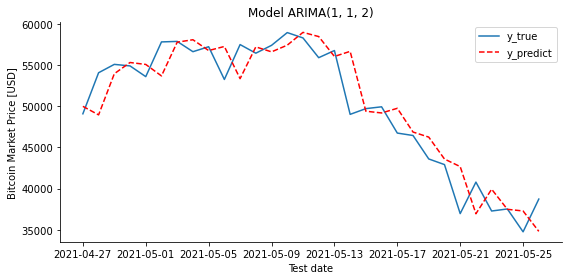

In [12]:
fig, ax = plt.subplots(figsize=(8,4))

sns.lineplot(x="date", y="true", data=df_predict, 
             ax=ax, label="y_true", markers=True )
plot_ = sns.lineplot(x="date",
             y="predict",
             data=df_predict,
             color="red",ax=ax, label="y_predict")
plot_.lines[1].set_linestyle("--")
new_ticks = plot_.get_xticklabels()
freq = 4
ax.set_xticks(np.arange(0, len(new_ticks), freq))
labels = predict_date[::freq]
ax.set_xticklabels(labels)
ax.set_ylabel("Bitcoin Market Price [USD]")
ax.set_xlabel("Test date")
ax.set_title(f"Model ARIMA{parameters}")
sns.despine()
plt.legend()
plt.tight_layout()

## Modeling with ARIMAX

In [13]:
# We now use the ARIMAX model.
# This means that we have to add an exogenous input to the ARIMA function.
# For the exogenous variable, we choose the feature 'miners-revenue', because it has one of the biggest intercorrelation with 'market-price'. 

mycolumns = ['miners-revenue']
trois_indicateur_train = X_train[mycolumns]
trois_indicateur_test = X_test[mycolumns]
b=trois_indicateur_test.dropna(0)

history = X_train["market-price"].values.tolist()

predictions_arimax = list()

for t in range(len(X_test)-1):
    if t==0:
        exogenous = X_train
    else:
        exogenous = exogenous.append(X_test.iloc[t])
    model = ARIMA(history, order=(1,1,2), exog = exogenous[mycolumns])
    model_fit = model.fit()
    yhat = model_fit.forecast(1, exog = b.values[t]).iloc[0]
    predictions_arimax.append(yhat)
    history += [X_test["market-price"].values[t]]

c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
c:\users\admin\anaconda3\envs\mds_env\lib\site-package

c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\anaconda3\envs\mds_env\lib\site-package

c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\anaconda3\envs\mds_env\lib\site-package

c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\anaconda3\envs\mds_env\lib\site-package

In [14]:
# We compute the root mean squared error of the ARIMAX model for the last 29 days.

error_arimax = np.sqrt(mean_squared_error(X_test['market-price'][:29], predictions_arimax))
print('The RMSE of the ARIMAX model is ' + str(error_arimax) + '.')

The RMSE of the ARIMAX model is 2780.514681712221.


In [15]:
# There is an offset between the dates of X_test['market-price'] and predictions_arimax.
# We remove this manually, as we know it corresponds to 3514 days.

new_predictions_arimax = (X_test['market-price']).copy()

for i in range(3514, 3543):
    new_predictions_arimax[i] = predictions_arimax[i-3514]
    
# Now, the dates of both tables overlap.

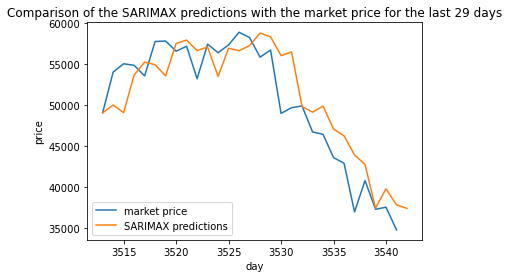

In [16]:
# We plot the evolution of the market price and of the arimax prediction.

plt.plot(X_test['market-price'][:29], label = 'market price')
plt.plot(new_predictions_arimax, label = 'SARIMAX predictions')
plt.title('Comparison of the SARIMAX predictions with the market price for the last 29 days')
plt.xlabel('day')
plt.ylabel('price')
plt.legend()

## Modeling with SARIMAX

In [17]:
# We now use the SARIMAX model.
# This means that we have to add :
# - an exogenous input to the ARIMA function.
# - a seasonal order, supposing that the market price has a seasonal evolution.
# We don't expect the SARIMAX model to work very well, because the market price of bitcoin doesn't seem to have a seasonal evolution.
# Adding a seasonal order would only correspond to an overfitting parameter.

# For the exogenous variable, we choose the feature 'miners-revenue', because it has one of the biggest intercorrelation with 'market-price'.


mycolumns = ['miners-revenue']
trois_indicateur_train = X_train[mycolumns]
trois_indicateur_test = X_test[mycolumns]
b=trois_indicateur_test.dropna(0)

history = X_train["market-price"].values.tolist()

predictions_sarimax = list()

for t in range(len(X_test)-1):
    if t==0:
        exogenous = X_train
    else:
        exogenous = exogenous.append(X_test.iloc[t])
    model = ARIMA(history, order=(2,1,1), seasonal_order = (1,1,2,4), exog = exogenous[mycolumns])
    model_fit = model.fit()
    yhat = model_fit.forecast(1, exog = b.values[t]).iloc[0]
    predictions_sarimax.append(yhat)
    history += [X_test["market-price"].values[t]]

c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\admin\anaconda3\

c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\anaconda3\envs\mds_env\lib\site-package

c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\anaconda3\envs\mds_env\lib\site-package

c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\admin\anaconda3\envs\mds_env\lib\site-package

In [20]:
# There is an offset between the dates of X_test['market-price'] and predictions_sarimax.
# We remove this manually, as we know it corresponds to 3514 days.

new_predictions_sarimax = (X_test['market-price']).copy()

for i in range(3514, 3543):
    new_predictions_sarimax[i] = predictions_arimax[i-3514]
    
# Now, the dates of both tables overlap.

In [21]:
# We compute the root mean squared error of the SARIMAX model for the last 29 days.

error_sarimax = np.sqrt(mean_squared_error(X_test['market-price'][:29], predictions_sarimax))

print('The RMSE of the SARIMAX model is ' + str(error_sarimax) + '.')

The RMSE of the SARIMAX model is 2935.8288070786016.


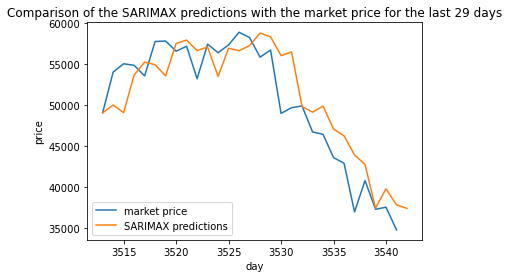

In [22]:
# We plot the evolution of the market price and of the sarimax prediction.

plt.plot(X_test['market-price'][:29], label = 'market price')
plt.plot(new_predictions_sarimax, label = 'SARIMAX predictions')
plt.title('Comparison of the SARIMAX predictions with the market price for the last 29 days')
plt.xlabel('day')
plt.ylabel('price')
plt.legend()

## GARCH model

In [35]:
# We use the GARCH model, with parameters p=2 and q=2.

model = arch_model(X_train['market-price'], p=2, q=2)
model_fit = model.fit()
model_fit.summary()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 14923.1827419388
Iteration:      2,   Func. Count:     17,   Neg. LLF: 14848.672008886544
Iteration:      3,   Func. Count:     25,   Neg. LLF: 14647.484359683553
Iteration:      4,   Func. Count:     33,   Neg. LLF: 14640.975117770584
Iteration:      5,   Func. Count:     41,   Neg. LLF: 14640.492561039839
Iteration:      6,   Func. Count:     49,   Neg. LLF: 14640.385046911015
Iteration:      7,   Func. Count:     57,   Neg. LLF: 14640.207828110415
Iteration:      8,   Func. Count:     65,   Neg. LLF: 14639.762692713772
Iteration:      9,   Func. Count:     73,   Neg. LLF: 14638.520274848957
Iteration:     10,   Func. Count:     81,   Neg. LLF: 14635.177565569129
Iteration:     11,   Func. Count:     89,   Neg. LLF: 14625.757537300367
Iteration:     12,   Func. Count:     97,   Neg. LLF: 14598.479433079367
Iteration:     13,   Func. Count:    105,   Neg. LLF: 14517.118084059832
Iteration:     14,   Func. Count:    113,   Neg. LLF:

c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.36e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:           market-price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -14220.1
Distribution:                  Normal   AIC:                           28452.3
Method:            Maximum Likelihood   BIC:                           28484.2
                                        No. Observations:                 1503
Date:                Fri, Jun 11 2021   Df Residuals:                     1502
Time:                        11:41:23   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu          7731.4528    142.063     54.423      0.000 [7.453e+03,8.010e+03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.7196e+06  9.671e+04     28.123 5.184e-174 [2.530e+06,2.909e+06]
alpha[1]       0.7698  8.836e-02      8.712  2.984e-18     [  0.597,  0.943]
alpha[2]       0.0000  9.333e-02      0.000      1.000     [ -0.183,  0.183]
beta[1]    1.2157e-13      0.193  6.298e-13      1.000     [ -0.378,  0.378]
beta[2]        0.0000      0.190      0.000      1.000     [ -0.372,  0.372]
============================================================================

Covariance estimator: robust
"""

In [36]:
predictions_garch = model_fit.forecast(horizon = 29)

c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


(0.0, 30.0)

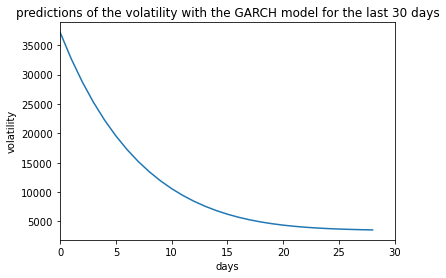

In [57]:
plt.figure()
# true, = plt.plot(X_test['market-price'])
preds, = plt.plot(np.sqrt(predictions_garch.variance.values[-1, :]))
plt.title("predictions of the volatility with the GARCH model for the last 30 days")
plt.xlabel("days")
plt.ylabel("volatility")
plt.xlim(0,30)

# Multivariate regression

In this section, we will try a multivariate linear regression model. At first, let's plot the features and the intercorrelation matrix.

In [39]:
# List of features

features = []
for col in df_blockchain.columns:
    features.append(col)
features.remove('Date') 

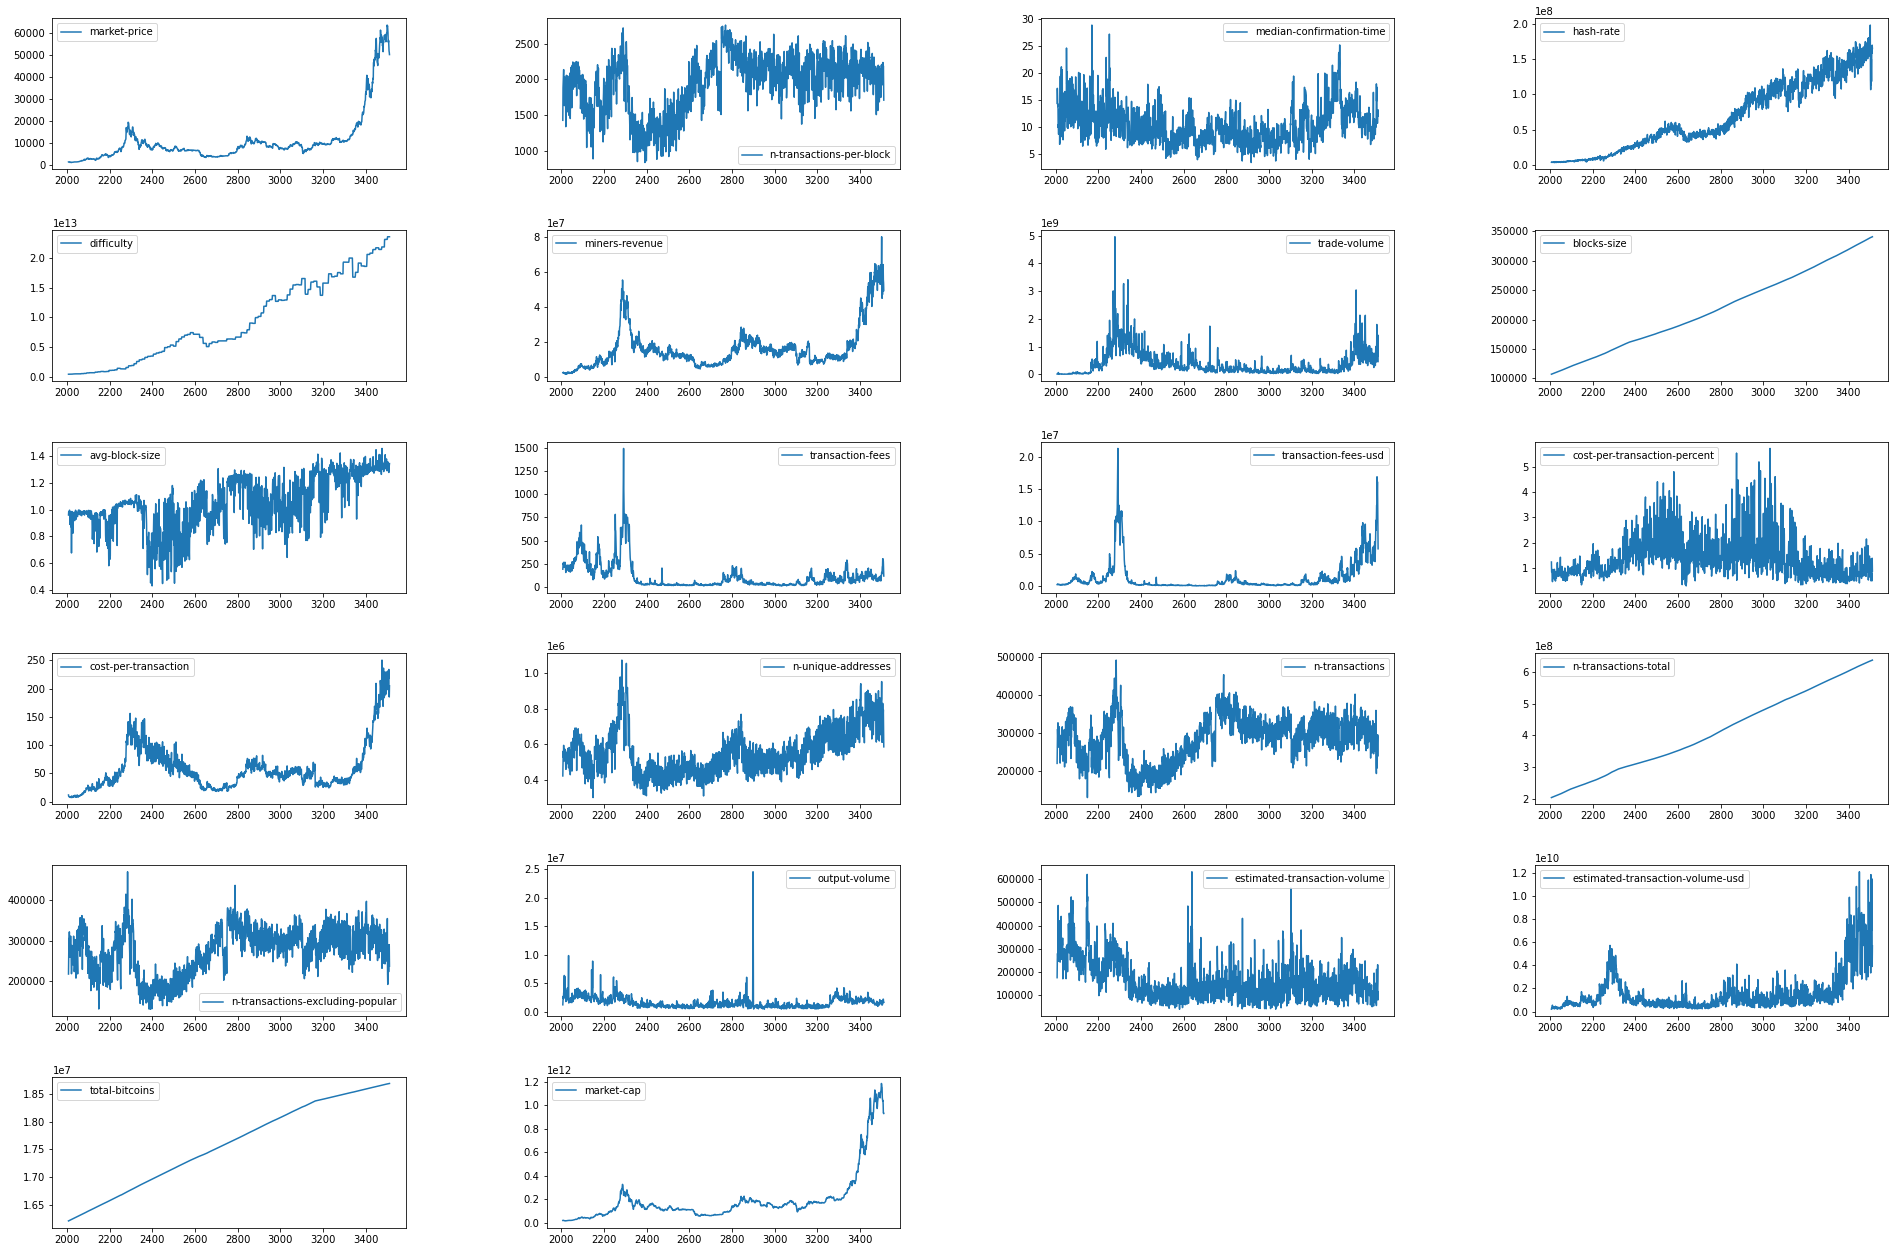

In [40]:
# Plot of the evolution of all the features

fig = plt.figure(figsize=(30, 24))
gs = gridspec.GridSpec(nrows = 6, ncols = 4, left = 0.1, bottom = 0.25, right = 0.95,top = 0.95,wspace = 0.4, hspace = 0.4)
for i in range(len(features)):
    ax = plt.subplot(gs[i])
    plt.plot(X_train[features[i]])
    plt.legend([features[i]])

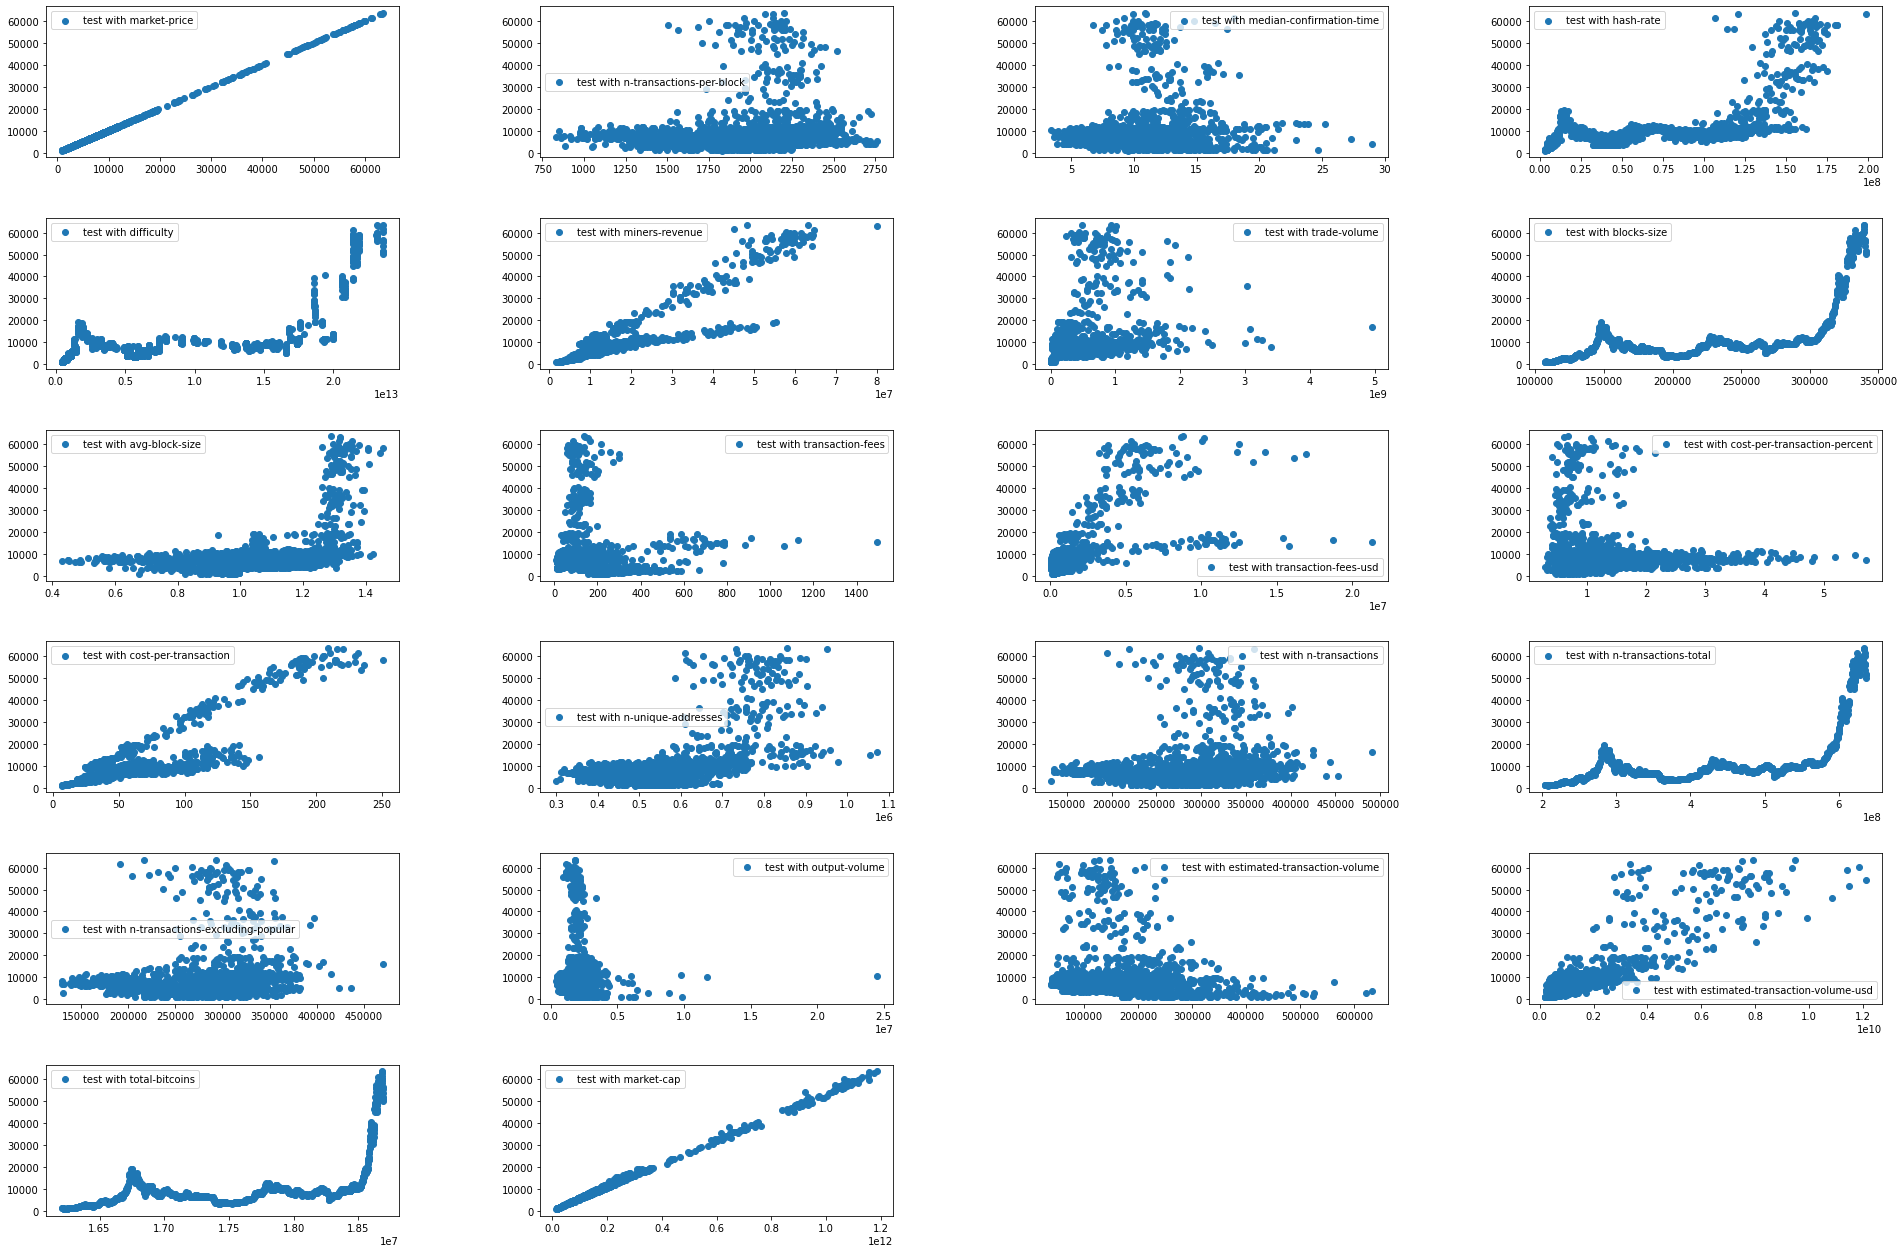

In [41]:
# Plot in face of market-price see if there are linearities

fig = plt.figure(figsize=(30, 24))
gs = gridspec.GridSpec(nrows = 6, ncols = 4, left = 0.1, bottom = 0.25, right = 0.95,top = 0.95,wspace = 0.4, hspace = 0.4)
for i in range(len(features)):
    ax = plt.subplot(gs[i])
    plt.scatter(X_train[features[i]], X_train["market-price"])
    plt.legend([f"test with {features[i]}"])

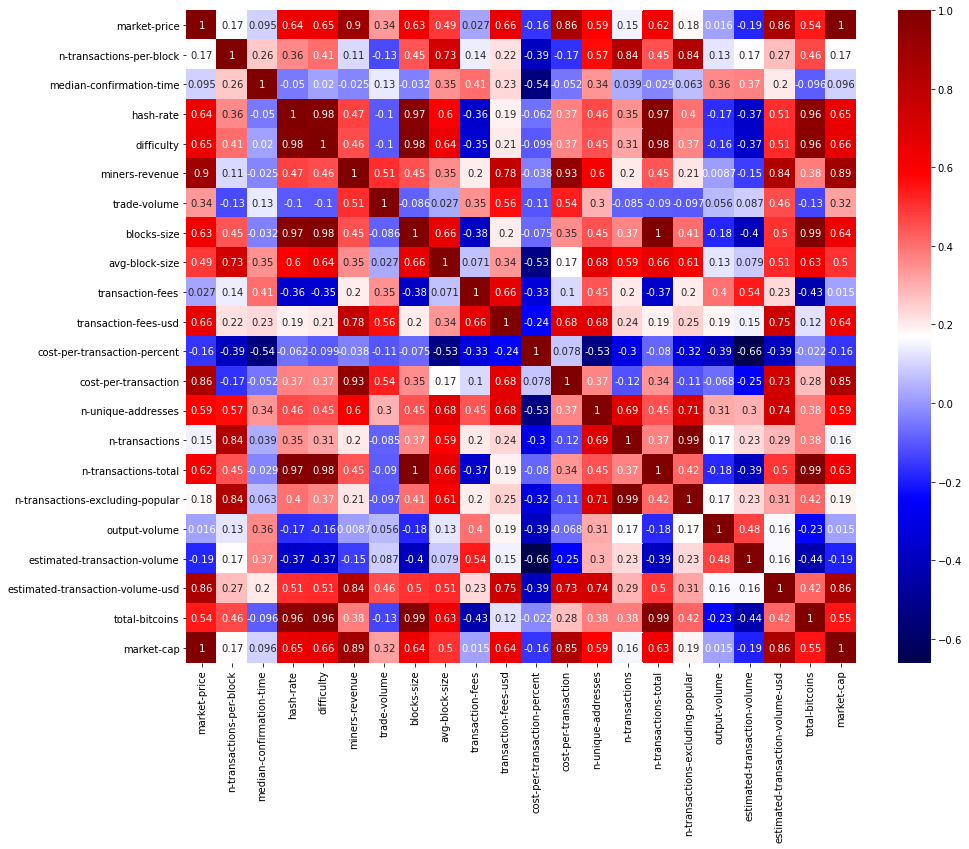

In [42]:
# Intercorrelation matrix

fig, ax = plt.subplots(figsize=(15, 12))
S = X_train[features].corr()
sns.heatmap(S, cmap='seismic', annot=True, ax=ax)
plt.show()

In [43]:
# Selection of features based on correlation

features_copy = deepcopy(features)
features_sel = []

# Drop too high correlation with market price (direct correlation ?)

for i in range(len(features_copy)):
    if abs(S['market-price'][i]) < 0.98:
        features_sel.append(features_copy[i])

# # Check for redundant features (see intercorrelation) --> doesn't work, too much intercorrelated variables

# redundant = []
# for feature in features_sel:
#     for i in range(len(features_sel)):
#         if feature != features_sel[i]:
#             if abs(S[feature][i]) > 0.95:
#                 redundant.append(features_sel[i])

# for feature in redundant:
#     try:
#         features_sel.remove(feature)
#     except ValueError:
#         pass

print(f"Regression with {len(features_sel)} features.")

Regression with 20 features.


In [44]:
# Linear regression with OLS

X = X_train[features_sel]
X = sm.tools.tools.add_constant(X)
y = X_train["market-price"]
ols_sel = sm.regression.linear_model.OLS(y, X.astype(float)).fit()
ols_sel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           market-price   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1905.
Date:                Fri, 11 Jun 2021   Prob (F-statistic):               0.00
Time:                        11:41:59   Log-Likelihood:                -13776.
No. Observations:                1503   AIC:                         2.759e+04
Df Residuals:                    1483   BIC:                         2.770e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               10.5974      2.319      4.569      0.000       6.048      15.147
n-transactions-per-block             1.0351      0.586      1.766      0.078      -0.115       2.185
median-confirmation-time            69.3937     26.872      2.582      0.010      16.683     122.104
hash-rate                        -6.306e-05   1.27e-05     -4.957      0.000    -8.8e-05   -3.81e-05
difficulty                        6.649e-10   1.03e-10      6.425      0.000    4.62e-10    8.68e-10
miners-revenue                       0.0005   3.79e-05     13.086      0.000       0.000       0.001
trade-volume                     -2.584e-06    1.9e-07    -13.626      0.000   -2.96e-06   -2.21e-06
blocks-size                          1.0373      0.043     24.021      0.000       0.953       1.122
avg-block-size                    3066.2359    721.421      4.250      0.000    1651.121    4481.351
transaction-fees                     7.1266      1.301      5.478      0.000       4.575       9.678
transaction-fees-usd                -0.0009   9.39e-05     -9.084      0.000      -0.001      -0.001
cost-per-transaction-percent      -760.4598    159.200     -4.777      0.000   -1072.741    -448.179
cost-per-transaction                72.3301      9.529      7.590      0.000      53.638      91.023
n-unique-addresses                   0.0039      0.002      2.474      0.013       0.001       0.007
n-transactions                      -0.2090      0.014    -14.427      0.000      -0.237      -0.181
n-transactions-total                -0.0005   2.26e-05    -23.907      0.000      -0.001      -0.000
n-transactions-excluding-popular     0.2032      0.014     14.083      0.000       0.175       0.231
output-volume                        0.0002   6.41e-05      3.294      0.001    8.53e-05       0.000
estimated-transaction-volume        -0.0055      0.002     -3.458      0.001      -0.009      -0.002
estimated-transaction-volume-usd  1.214e-06   1.18e-07     10.287      0.000    9.83e-07    1.45e-06
total-bitcoins                      -0.0006    8.3e-05     -7.104      0.000      -0.001      -0.000
==============================================================================
Omnibus:                       77.971   Durbin-Watson:                   0.637
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.877
Skew:                           0.328   Prob(JB):                     3.51e-37
Kurtosis:                       4.500   Cond. No.                     3.91e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.91e+15. This might indicate that there are
st

RMS: 2313.66$


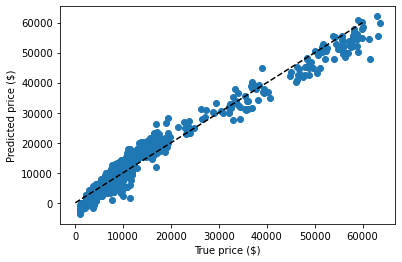

In [45]:
# See the regression 

X = X_train[features_sel]
X = sm.tools.tools.add_constant(X)
predicted = ols_sel.predict(X)
expected = X_train['market-price']

plt.scatter(expected, predicted)
plt.plot([0, 60000], [0, 60000], '--k')
plt.axis('tight')
plt.xlabel('True price ($)')
plt.ylabel('Predicted price ($)')
print("RMS: {:.2f}$".format(np.sqrt(np.mean((predicted - expected) ** 2))))

RMS: 5268.60$


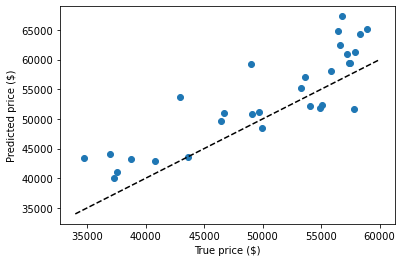

In [46]:
# Predictions

X_pred = X_test[features_sel]
X_pred = sm.tools.tools.add_constant(X_pred)
predicted = ols_sel.predict(X_pred)
expected = X_test['market-price']

plt.scatter(expected, predicted)
plt.plot([34000, 60000], [34000, 60000], '--k')
plt.axis('tight')
plt.xlabel('True price ($)')
plt.ylabel('Predicted price ($)')
print("RMS: {:.2f}$".format(np.sqrt(np.mean((predicted - expected) ** 2))))

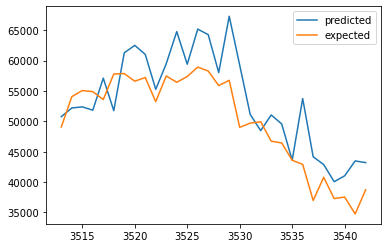

In [47]:
plt.plot(predicted, label="predicted")
plt.plot(expected, label="expected")
plt.legend()
plt.show()

We remarked that the p-values are >>> 0.001 for 'n-transactions-per-block', 'n-unique-addresses'. Let's try to remove them from the features' list.

In [48]:
from copy import deepcopy

# Selection of features based on p-value

H0_rejected = ['n-transactions-per-block', 'n-unique-addresses']

features_sel2 = deepcopy(features_sel)
for feature in H0_rejected :
    features_sel2.remove(feature)
    
# Linear regression with OLS

X = X_train[features_sel2] 
X = sm.tools.tools.add_constant(X)
y = X_train["market-price"]
ols_sel = sm.regression.linear_model.OLS(y, X.astype(float)).fit()
ols_sel.summary() 
    

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           market-price   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     2121.
Date:                Fri, 11 Jun 2021   Prob (F-statistic):               0.00
Time:                        11:41:59   Log-Likelihood:                -13779.
No. Observations:                1503   AIC:                         2.759e+04
Df Residuals:                    1485   BIC:                         2.769e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                5.3875      0.776      6.941      0.000       3.865       6.910
median-confirmation-time            92.6396     25.357      3.653      0.000      42.901     142.379
hash-rate                        -7.325e-05   9.43e-06     -7.764      0.000   -9.18e-05   -5.47e-05
difficulty                        7.685e-10   8.28e-11      9.277      0.000    6.06e-10    9.31e-10
miners-revenue                       0.0005   3.71e-05     13.845      0.000       0.000       0.001
trade-volume                      -2.51e-06   1.87e-07    -13.428      0.000   -2.88e-06   -2.14e-06
blocks-size                          1.0361      0.043     24.017      0.000       0.951       1.121
avg-block-size                    3483.8904    690.666      5.044      0.000    2129.106    4838.675
transaction-fees                     7.7461      1.272      6.091      0.000       5.252      10.241
transaction-fees-usd                -0.0008   9.39e-05     -8.959      0.000      -0.001      -0.001
cost-per-transaction-percent      -877.0337    151.289     -5.797      0.000   -1173.796    -580.271
cost-per-transaction                67.1281      9.139      7.345      0.000      49.201      85.056
n-transactions                      -0.2009      0.014    -14.360      0.000      -0.228      -0.173
n-transactions-total                -0.0005   2.26e-05    -23.937      0.000      -0.001      -0.000
n-transactions-excluding-popular     0.2035      0.014     14.108      0.000       0.175       0.232
output-volume                        0.0002   6.34e-05      3.516      0.000    9.85e-05       0.000
estimated-transaction-volume        -0.0063      0.002     -3.952      0.000      -0.009      -0.003
estimated-transaction-volume-usd   1.28e-06   1.15e-07     11.107      0.000    1.05e-06    1.51e-06
total-bitcoins                      -0.0005   7.69e-05     -6.596      0.000      -0.001      -0.000
==============================================================================
Omnibus:                       74.817   Durbin-Watson:                   0.645
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              163.993
Skew:                           0.307   Prob(JB):                     2.45e-36
Kurtosis:                       4.497   Cond. No.                     3.67e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.67e+15. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

RMS: 5370.42$


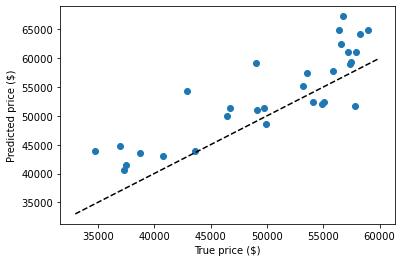

In [49]:
# Predictions

X_pred = X_test[features_sel2]
X_pred = sm.tools.tools.add_constant(X_pred)
predicted = ols_sel.predict(X_pred)
expected = X_test['market-price']

plt.scatter(expected, predicted)
plt.plot([33000, 60000], [33000, 60000], '--k')
plt.axis('tight')
plt.xlabel('True price ($)')
plt.ylabel('Predicted price ($)')
print("RMS: {:.2f}$".format(np.sqrt(np.mean((predicted - expected) ** 2))))

Both the AIC and the RMSE increased. We can emit the hypothesis of an overfitting due to a too large number of features.

## Preprocessing with Min-Max

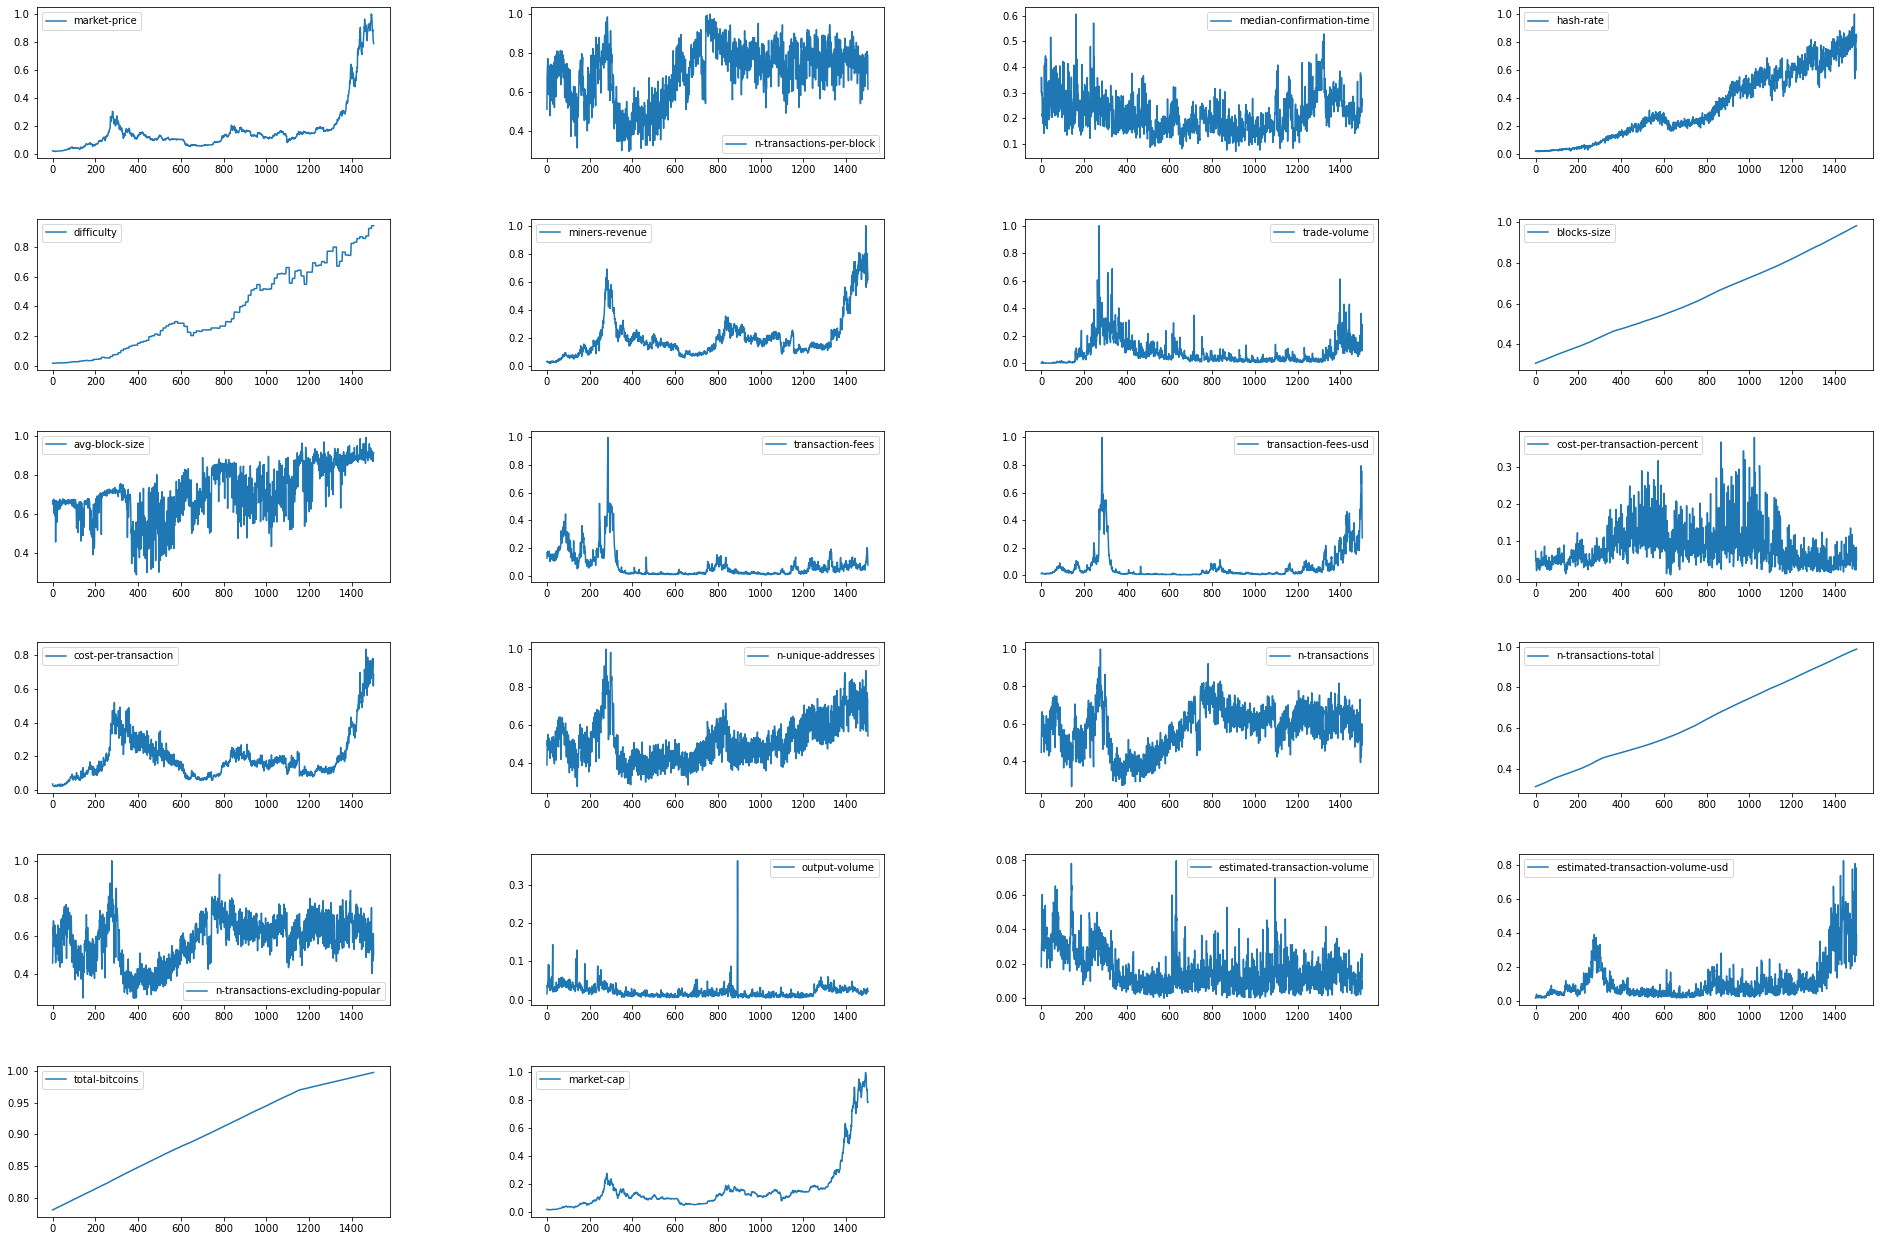

In [50]:
# MinMax preprocessing

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = df_blockchain_no_nans[features]
dataset = scaler.fit_transform(dataset.values.reshape(-1,len(features)))
dataset_train, dataset_test = dataset[beginning_date:-30], dataset[-30:]
X_train_scaled = pd.DataFrame(dataset_train)
X_train_scaled.columns = features
X_test_scaled = pd.DataFrame(dataset_test)
X_test_scaled.columns = features


# Data vizualisation
fig = plt.figure(figsize=(30, 24))
gs = gridspec.GridSpec(nrows = 6, ncols = 4, left = 0.1, bottom = 0.25, right = 0.95,top = 0.95,wspace = 0.4, hspace = 0.4)
for i in range(len(features)):
    ax = plt.subplot(gs[i])
    plt.plot(X_train_scaled[features[i]])
    plt.legend([features[i]])
    

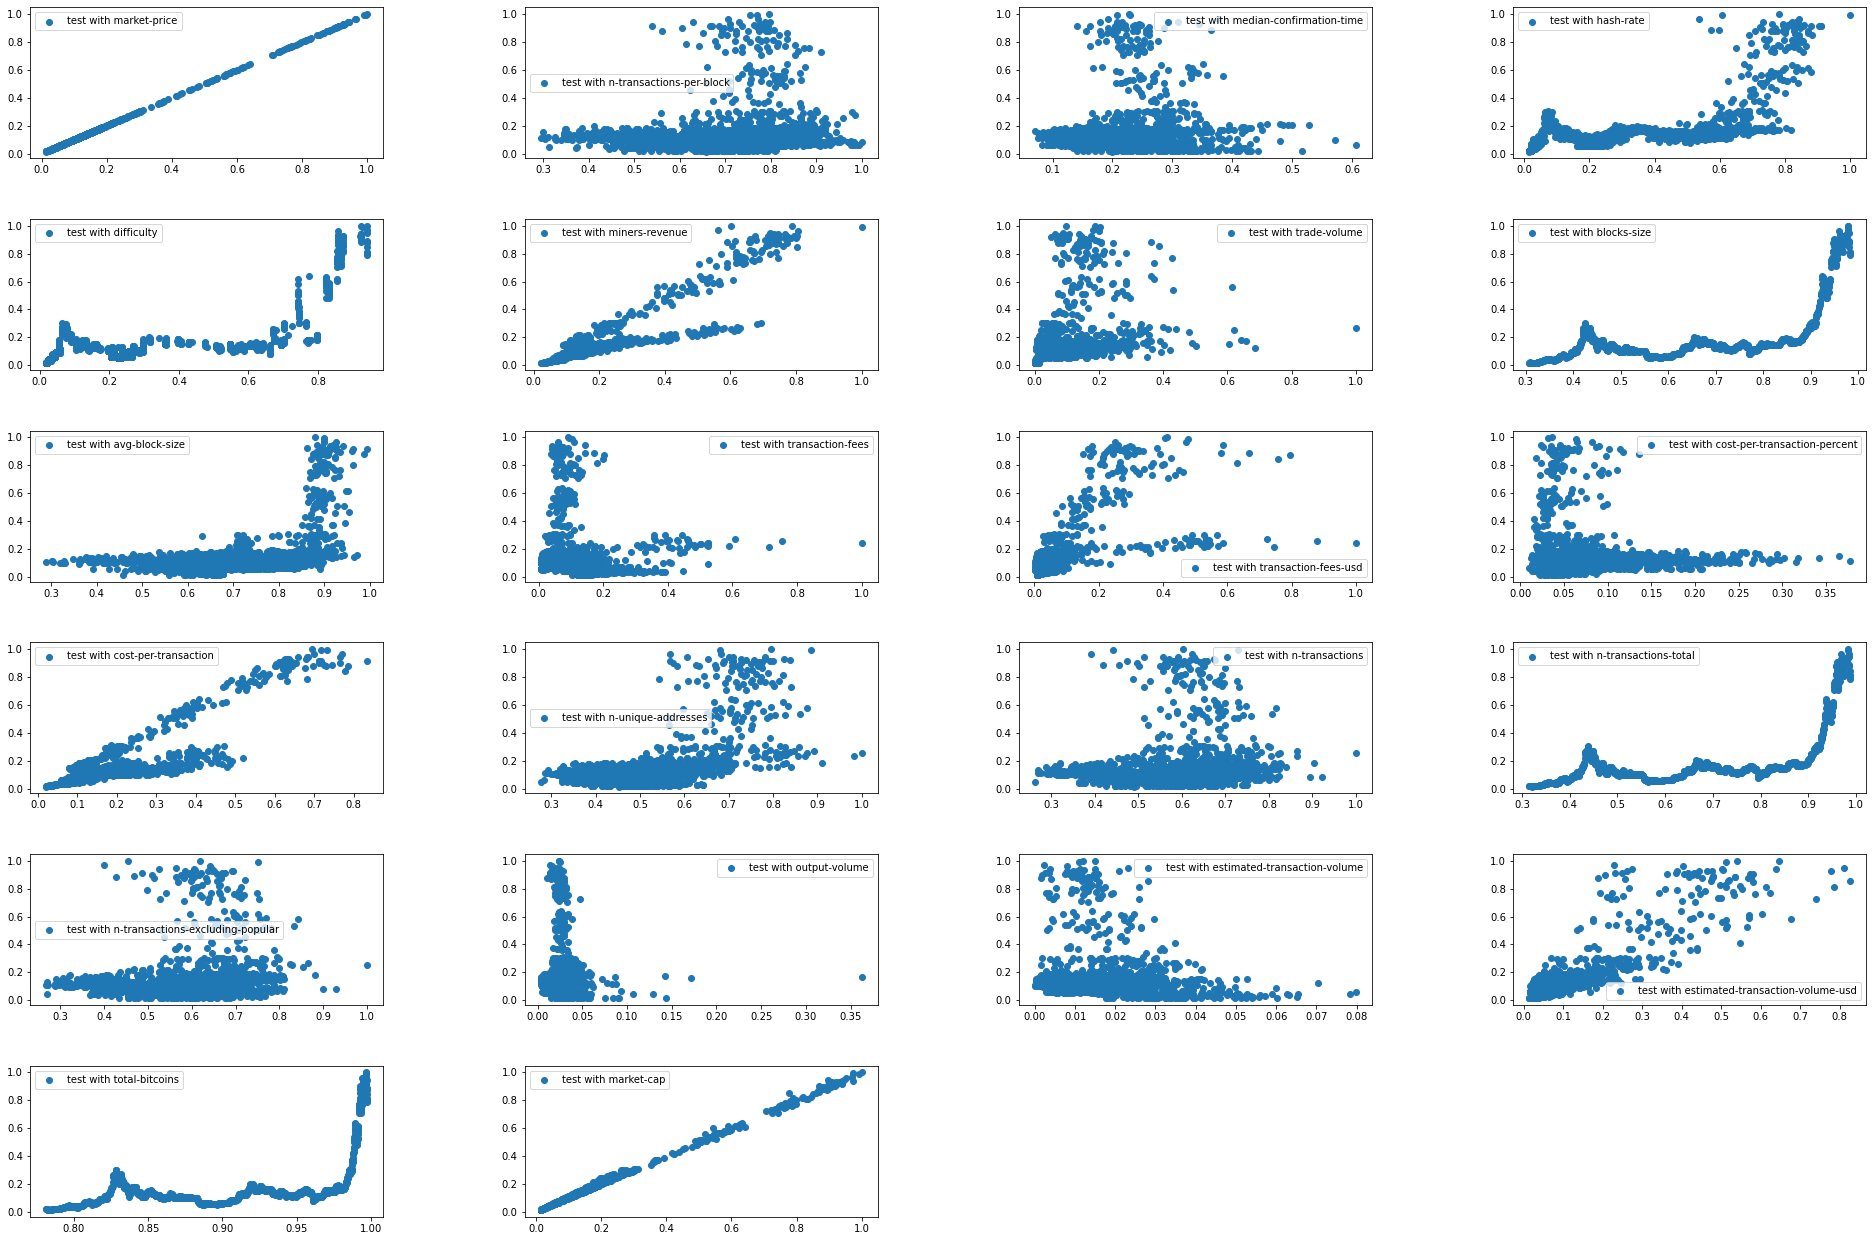

In [51]:
fig = plt.figure(figsize=(30, 24))
gs = gridspec.GridSpec(nrows = 6, ncols = 4, left = 0.1, bottom = 0.25, right = 0.95,top = 0.95,wspace = 0.4, hspace = 0.4)
for i in range(len(features)):
    ax = plt.subplot(gs[i])
    plt.scatter(X_train_scaled[features[i]], X_train_scaled["market-price"])
    plt.legend([f"test with {features[i]}"])

In [52]:
# Linear regression with OLS

X = X_train_scaled[features_sel]
X = sm.tools.tools.add_constant(X)
y = X_train_scaled["market-price"]
ols_sel = sm.regression.linear_model.OLS(y, X.astype(float)).fit()
ols_sel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           market-price   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     3934.
Date:                Fri, 11 Jun 2021   Prob (F-statistic):               0.00
Time:                        11:42:07   Log-Likelihood:                 3414.7
No. Observations:                1503   AIC:                            -6787.
Df Residuals:                    1482   BIC:                            -6676.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                4.6447      0.115     40.225      0.000       4.418       4.871
n-transactions-per-block             0.2072      0.018     11.686      0.000       0.172       0.242
median-confirmation-time            -0.1413      0.015     -9.662      0.000      -0.170      -0.113
hash-rate                           -0.1252      0.027     -4.587      0.000      -0.179      -0.072
difficulty                           0.1722      0.028      6.138      0.000       0.117       0.227
miners-revenue                       0.5915      0.033     18.042      0.000       0.527       0.656
trade-volume                        -0.0892      0.011     -8.487      0.000      -0.110      -0.069
blocks-size                          5.5177      0.161     34.198      0.000       5.201       5.834
avg-block-size                       0.0271      0.011      2.395      0.017       0.005       0.049
transaction-fees                    -0.0689      0.022     -3.166      0.002      -0.112      -0.026
transaction-fees-usd                -0.1020      0.022     -4.630      0.000      -0.145      -0.059
cost-per-transaction-percent        -0.0822      0.025     -3.227      0.001      -0.132      -0.032
cost-per-transaction                 0.2002      0.031      6.461      0.000       0.139       0.261
n-unique-addresses                  -0.0675      0.019     -3.644      0.000      -0.104      -0.031
n-transactions                      -0.4291      0.081     -5.289      0.000      -0.588      -0.270
n-transactions-total                -2.9398      0.169    -17.441      0.000      -3.270      -2.609
n-transactions-excluding-popular     0.3186      0.078      4.086      0.000       0.166       0.472
output-volume                       -0.1880      0.047     -3.960      0.000      -0.281      -0.095
estimated-transaction-volume        -0.2502      0.129     -1.937      0.053      -0.504       0.003
estimated-transaction-volume-usd     0.1100      0.019      5.759      0.000       0.073       0.147
total-bitcoins                      -6.9330      0.167    -41.465      0.000      -7.261      -6.605
==============================================================================
Omnibus:                      120.931   Durbin-Watson:                   0.533
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              487.717
Skew:                           0.284   Prob(JB):                    1.24e-106
Kurtosis:                       5.732   Cond. No.                         852.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

AIC =  -6787.446798490175
RMS: 5861.51$


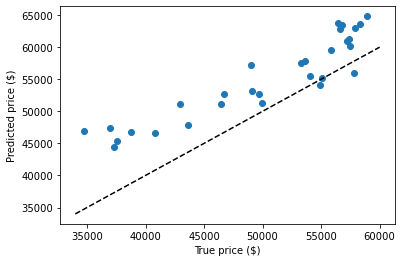

In [53]:
# New scaler just for market-price

scaler_mp = MinMaxScaler(feature_range=(0, 1))
data = df_blockchain_no_nans['market-price']
data = scaler_mp.fit_transform(data.values.reshape(-1,1))

# Predictions

X_pred = X_test_scaled[features_sel]
X_pred = sm.tools.tools.add_constant(X_pred)
predicted = scaler_mp.inverse_transform(ols_sel.predict(X_pred).to_numpy().reshape(-1,1)).reshape(30)
expected = X_test['market-price']

plt.scatter(expected, predicted)
plt.plot([34000, 60000], [34000, 60000], '--k')
plt.axis('tight')
plt.xlabel('True price ($)')
plt.ylabel('Predicted price ($)')
print("AIC = ",ols_sel.aic)
print("RMS: {:.2f}$".format(np.sqrt(np.mean((predicted - expected) ** 2))))



Offsets due to problems with the standardization ?

## min-AIC model for all combinations
To solve the overfitting problem, let's restrict to a maximum of 8 features.

In [54]:
AIC = {}
RMS = {}
N = 8 # Size of the biggest combination
for L in range(2,N+1):
    print(f"Processing for {L}-combinations ...")
    for subset in itertools.combinations(features_sel,L):
        features = list(subset)
        
        # for AIC
        X = X_train[features] 
        X = sm.tools.tools.add_constant(X)
        y = X_train["market-price"]
        ols = sm.regression.linear_model.OLS(y, X.astype(float)).fit()
        AIC[subset] = ols.aic
                
        # for MSE
        X_to_pred = X_test[features]
        X_to_pred = sm.tools.tools.add_constant(X_to_pred)
        predicted = ols.predict(X_to_pred)
        expected = X_test['market-price']
        RMS[subset] = np.sqrt(np.mean((predicted - expected) ** 2))

Processing for 2-combinations ...
Processing for 3-combinations ...
Processing for 4-combinations ...
Processing for 5-combinations ...
Processing for 6-combinations ...


KeyboardInterrupt: 

In [58]:
# for N = 8 --> found by running the previous cell on a separated Google Colab

best_AIC_8 = [('difficulty', 'miners-revenue', 'trade-volume', 'blocks-size', 'avg-block-size', 'n-transactions', 'n-transactions-total', 'estimated-transaction-volume-usd'), ('difficulty', 'miners-revenue', 'blocks-size', 'avg-block-size', 'n-transactions', 'n-transactions-total', 'n-transactions-excluding-popular', 'estimated-transaction-volume-usd'), ('difficulty', 'miners-revenue', 'trade-volume', 'blocks-size', 'n-transactions', 'n-transactions-total', 'n-transactions-excluding-popular', 'estimated-transaction-volume-usd'), ('difficulty', 'miners-revenue', 'trade-volume', 'blocks-size', 'avg-block-size', 'n-transactions-total', 'n-transactions-excluding-popular', 'estimated-transaction-volume-usd'), ('hash-rate', 'difficulty', 'miners-revenue', 'blocks-size', 'n-transactions', 'n-transactions-total', 'n-transactions-excluding-popular', 'estimated-transaction-volume-usd'), ('miners-revenue', 'trade-volume', 'blocks-size', 'avg-block-size', 'n-transactions', 'n-transactions-total', 'n-transactions-excluding-popular', 'estimated-transaction-volume-usd'), ('n-transactions-per-block', 'miners-revenue', 'trade-volume', 'blocks-size', 'n-transactions', 'n-transactions-total', 'n-transactions-excluding-popular', 'estimated-transaction-volume-usd'), ('median-confirmation-time', 'miners-revenue', 'trade-volume', 'blocks-size', 'n-transactions', 'n-transactions-total', 'n-transactions-excluding-popular', 'estimated-transaction-volume-usd'), ('difficulty', 'miners-revenue', 'trade-volume', 'blocks-size', 'avg-block-size', 'cost-per-transaction', 'n-transactions-total', 'estimated-transaction-volume-usd'), ('median-confirmation-time', 'difficulty', 'miners-revenue', 'trade-volume', 'blocks-size', 'cost-per-transaction', 'n-transactions-total', 'estimated-transaction-volume-usd')]
best_RMS_8 = [('hash-rate', 'difficulty', 'miners-revenue', 'trade-volume', 'blocks-size', 'n-transactions', 'n-transactions-total', 'n-transactions-excluding-popular'), ('n-transactions-per-block', 'hash-rate', 'difficulty', 'miners-revenue', 'trade-volume', 'blocks-size', 'avg-block-size', 'n-transactions-total'), ('hash-rate', 'difficulty', 'miners-revenue', 'trade-volume', 'blocks-size', 'avg-block-size', 'cost-per-transaction', 'n-transactions-total'), ('hash-rate', 'difficulty', 'miners-revenue', 'trade-volume', 'blocks-size', 'cost-per-transaction-percent', 'cost-per-transaction', 'n-transactions-total'), ('hash-rate', 'difficulty', 'miners-revenue', 'trade-volume', 'blocks-size', 'avg-block-size', 'n-transactions-total', 'n-transactions-excluding-popular'), ('median-confirmation-time', 'hash-rate', 'difficulty', 'miners-revenue', 'trade-volume', 'blocks-size', 'cost-per-transaction', 'n-transactions-total'), ('hash-rate', 'difficulty', 'miners-revenue', 'trade-volume', 'blocks-size', 'avg-block-size', 'n-transactions', 'n-transactions-total'), ('median-confirmation-time', 'hash-rate', 'difficulty', 'miners-revenue', 'trade-volume', 'blocks-size', 'avg-block-size', 'n-transactions-total'), ('hash-rate', 'difficulty', 'miners-revenue', 'trade-volume', 'blocks-size', 'avg-block-size', 'cost-per-transaction-percent', 'n-transactions-total'), ('hash-rate', 'difficulty', 'miners-revenue', 'trade-volume', 'blocks-size', 'avg-block-size', 'transaction-fees-usd', 'n-transactions-total')]

print(best_RMS_8[0])

('hash-rate', 'difficulty', 'miners-revenue', 'trade-volume', 'blocks-size', 'n-transactions', 'n-transactions-total', 'n-transactions-excluding-popular')


In [59]:
# Linear regression with best compromise

features_best = list(best_RMS_8[0])

X = X_train[features_best]
X = sm.tools.tools.add_constant(X)
y = X_train['market-price']
ols = sm.regression.linear_model.OLS(y, X.astype(float)).fit()
ols.summary()

print(features_best)


['hash-rate', 'difficulty', 'miners-revenue', 'trade-volume', 'blocks-size', 'n-transactions', 'n-transactions-total', 'n-transactions-excluding-popular']


AIC =  28240.1610559322
RMS: 2225.36$


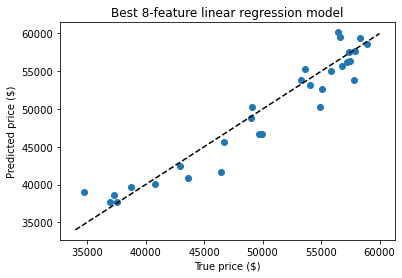

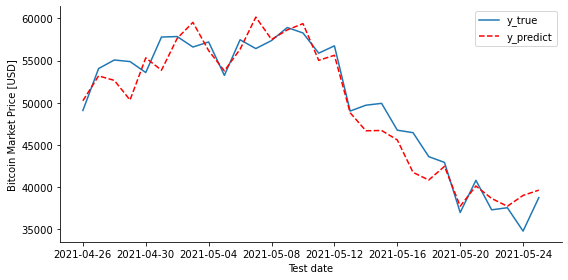

In [60]:
# Predictions

X_to_pred = X_test[features_best]
X_to_pred = sm.tools.tools.add_constant(X_to_pred)
predicted = ols.predict(X_to_pred)
expected = X_test['market-price']
RMS = np.sqrt(np.mean((predicted - expected) ** 2))

plt.scatter(expected, predicted)
plt.plot([34000, 60000], [34000, 60000], '--k')
plt.axis('tight')
plt.xlabel('True price ($)')
plt.ylabel('Predicted price ($)')
plt.title("Best 8-feature linear regression model")
print("AIC = ",ols.aic)
print("RMS: {:.2f}$".format(RMS))

# prepare the dataset for plotting
predict_date = df_blockchain_no_nans.iloc[-30::]["Date"]
df_predict = pd.DataFrame(zip(predict_date,
                              predicted, X_test["market-price"].values),
                          columns=["date", "predict", "true"])

fig, ax = plt.subplots(figsize=(8,4))

sns.lineplot(x="date", y="true", data=df_predict, 
             ax=ax, label="y_true", markers=True )
plot_ = sns.lineplot(x="date",
             y="predict",
             data=df_predict,
             color="red",ax=ax, label="y_predict")
plot_.lines[1].set_linestyle("--")
new_ticks = plot_.get_xticklabels()
freq = 4
ax.set_xticks(np.arange(0, len(new_ticks), freq))
labels = predict_date[::freq]
ax.set_xticklabels(labels)
ax.set_ylabel("Bitcoin Market Price [USD]")
ax.set_xlabel("Test date")
sns.despine()
plt.legend()
plt.tight_layout()

AIC =  28240.1610559322
RMS: 2257.38$


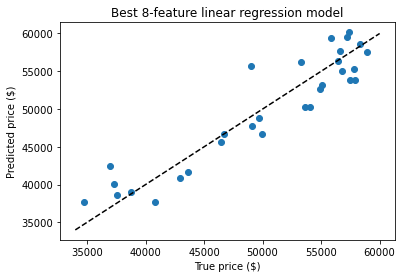

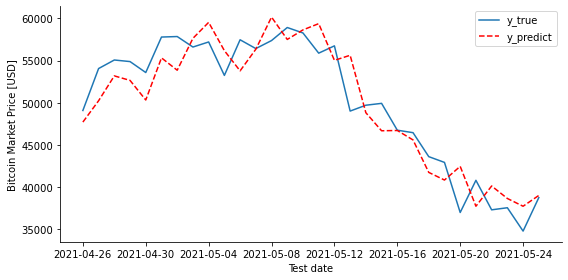

In [78]:
# Predictions with tight offset

offset_days = 1

X_to_pred = df_blockchain_no_nans[features_best][-(30+offset_days):-offset_days]
X_to_pred = sm.tools.tools.add_constant(X_to_pred)
predicted = ols.predict(X_to_pred)
expected = X_test['market-price']
RMS = np.sqrt(np.mean((predicted - expected) ** 2))

plt.scatter(expected, predicted)
plt.plot([34000, 60000], [34000, 60000], '--k')
plt.axis('tight')
plt.xlabel('True price ($)')
plt.ylabel('Predicted price ($)')
plt.title("Best 8-feature linear regression model")
print("AIC = ",ols.aic)
print("RMS: {:.2f}$".format(RMS))

# prepare the dataset for plotting
predict_date = df_blockchain_no_nans.iloc[-30::]["Date"]
df_predict = pd.DataFrame(zip(predict_date,
                              predicted, X_test["market-price"].values),
                          columns=["date", "predict", "true"])

fig, ax = plt.subplots(figsize=(8,4))

sns.lineplot(x="date", y="true", data=df_predict, 
             ax=ax, label="y_true", markers=True )
plot_ = sns.lineplot(x="date",
             y="predict",
             data=df_predict,
             color="red",ax=ax, label="y_predict")
plot_.lines[1].set_linestyle("--")
new_ticks = plot_.get_xticklabels()
freq = 4
ax.set_xticks(np.arange(0, len(new_ticks), freq))
labels = predict_date[::freq]
ax.set_xticklabels(labels)
ax.set_ylabel("Bitcoin Market Price [USD]")
ax.set_xlabel("Test date")
sns.despine()
plt.legend()
plt.tight_layout()

## Lasso and ridge regularization

(-3.225, 1.725, -0.03562535660625676, 0.7481324887313919)

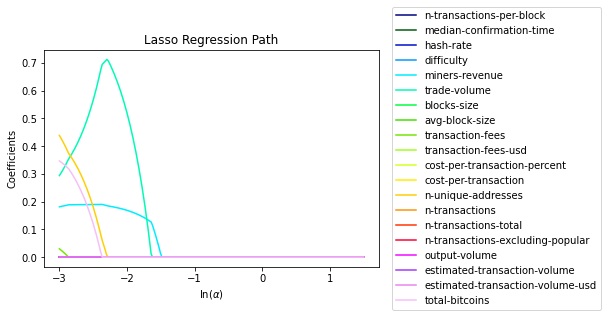

In [79]:
# Using ElasticNet

als=np.logspace(-3, 1.5, 200)
coefs=[]
X = X_train_scaled[features_sel] 
X = sm.tools.tools.add_constant(X)
y = X_train_scaled["market-price"]
for al in als:
    reg = ElasticNet(alpha=al,l1_ratio=1)
    reg.fit(X, y)
    coefs.append(reg.coef_)
    
# A list of different colors to draw our coefficients
colormap = plt.cm.gist_ncar 
colorst = [colormap(i) for i in np.linspace(0, 0.95,len(features_sel))]

for i in range(len(features_sel)):
    plt.plot(np.log10(als), [x[i] for x in coefs], label=features_sel[i], color=colorst[i])
plt.xlabel(r'$\ln(\alpha)$')
plt.ylabel('Coefficients')
plt.title('Lasso Regression Path')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.axis('tight')

c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.018931299384497, tolerance: 0.005060269683751858
  positive)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.043190337446518, tolerance: 0.005060269683751858
  positive)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0683522032078097, tolerance: 0.005060269683751858
  positive)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3585130986573457, tolerance: 0.005060269683751858
  positive)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.429114287480373, tolerance: 0.005060269683751858
  positive)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5020122691342435, tolerance: 0.005060269683751858
  positive)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge.

c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.943323224599732, tolerance: 0.005060269683751858
  positive)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.117751938209658, tolerance: 0.005060269683751858
  positive)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.296252510677176, tolerance: 0.005060269683751858
  positive)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. Y

c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.643934734487576, tolerance: 0.005060269683751858
  positive)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.899784121101689, tolerance: 0.005060269683751858
  positive)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.155881149835215, tolerance: 0.005060269683751858
  positive)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge

c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.590874658090396, tolerance: 0.005060269683751858
  positive)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.769188180493416, tolerance: 0.005060269683751858
  positive)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.94284244946015, tolerance: 0.005060269683751858
  positive)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge.

c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.984304541621814, tolerance: 0.005060269683751858
  positive)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.04621179049354, tolerance: 0.005060269683751858
  positive)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.105426789173787, tolerance: 0.005060269683751858
  positive)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge.

c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.99167432119366, tolerance: 0.005060269683751858
  positive)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.007111952680926, tolerance: 0.005060269683751858
  positive)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.02179294883699, tolerance: 0.005060269683751858
  positive)
c:\users\admin\anaconda3\envs\mds_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

(-3.225, 1.725, -0.20238801194091546, 0.4561902289834806)

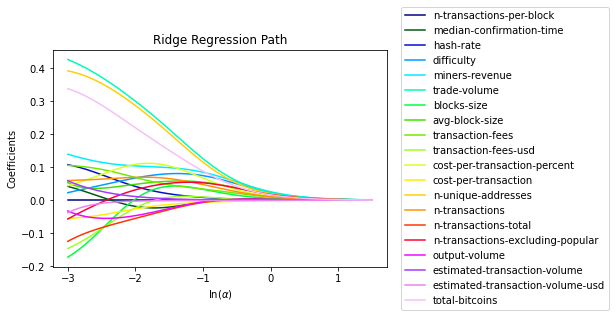

In [80]:
# Using ElasticNet

als=np.logspace(-3, 1.5, 200)
coefs=[]
X = X_train_scaled[features_sel] 
X = sm.tools.tools.add_constant(X)
y = X_train_scaled["market-price"]
for al in als:
    reg = ElasticNet(alpha=al,l1_ratio=0)
    reg.fit(X, y)
    coefs.append(reg.coef_)
    
# A list of different colors to draw our coefficients
colormap = plt.cm.gist_ncar 
colorst = [colormap(i) for i in np.linspace(0, 0.95,len(features_sel))]

for i in range(len(features_sel)):
    plt.plot(np.log10(als), [x[i] for x in coefs], label=features_sel[i], color=colorst[i])
plt.xlabel(r'$\ln(\alpha)$')
plt.ylabel('Coefficients')
plt.title('Ridge Regression Path')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.axis('tight')